In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Ward D Election Results

Brendan Doohan  
March 29, 2018

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [3]:
import os
#os.chdir("C:\\Users\\nwdoohanbr\\Desktop\\WardD\\Jersey-City-Ward-D-Election")
os.chdir("/Users/brendandoohan/Desktop/Jersey City Ward D Election/Jersey-City-Ward-D-Election")

In [4]:
ages = pd.read_csv("JC_WARD_D_2017_NOV_GEN_W_DOB.csv")

In [5]:
from datetime import datetime
from datetime import *
TODAY = datetime.today()
ages["bday"] = ages[ages['BIRTH DATE'] != 'UNITED STATES']['BIRTH DATE'].fillna('2/20/2018').astype(str).apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [6]:
import datetime

def age(dob):
    #dob = datetime.date(dob)
    today = datetime.date.today()
    years = today.year - dob.year
    if today.month < dob.month or (today.month == dob.month and today.day < dob.day):
        years -= 1
    return years

In [7]:
ages["Age"]  = ages['bday'].apply(lambda x: age(x))

In [102]:
ages = ages[ages.DISTRICT != "JERSEY CITY"].copy()
ages["DISTRICT"] = ages.DISTRICT.astype(float)

In [9]:
age_df = pd.DataFrame(
    ages[ages.Age < 110].groupby('DISTRICT')["Age"].mean()
)
age_df["District"] = age_df.index
age_df.to_csv("Age_info.csv", index=False)

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/District%20Guide.jpeg?raw=true" alt="Districts" height="600" width="600" align="right" hspace=0>
<p align="left">This whitepaper analyzes the results of Jersey City city council race for Ward D that was held on November 7th. In that election, incumbent Michael Yun ("Yun") ran against Moriah Kinberg ("Mo"), Carmen Vega ("Vega") and Rafael Torres ("Torres"). Yun won the election.</p>  

- Yun won with **2,613** votes \*    
- Mo had **1,335** votes  
- Vega had **397** votes    
- Torres had **131** votes

<sub>* These numbers are taken from the voting machine printouts from November 7th. The final totals cannot be broken out from the data given by the Board of Elections.</sub>  
<p>This paper breaks down the results by district, race, and candidate. The predictive model used to identify likely voters is also analyzed.</p>
<br clear="left"></br>
<p>Specifically, this paper addresses the following questions:</p> 

In [10]:
results = pd.read_csv("JC_WARD_D_edited.csv", header=0, error_bad_lines=False, verbose=False, encoding="UTF-7")

In [11]:
results = results.drop('Unnamed: 8', axis=1)

### Questions to Ask

1. How was turnout by district?
2. What was the racial makeup of those who did vote?
3. Did Mo's supporters come out and vote? 
4. Where did Mo perform best? How about the rest of the candidates?
5. Was the [Random Forest model](https://en.wikipedia.org/wiki/Random_forest) successful in identifying likely voters?

The paper then concludes by aggregating these insights to summarize what can be learned from the results of election. The insights aim to shed light on the voting behavior of Ward D--a ward experiencing rapid changes in terms of development and demographics.

### Let's look at Age by district first

Let;s first look at the distribution of ages across the districts. Districts with big bumps on the left side are younger than average; those with bumps on the right hand side are older.

District 1, for example, is younger than District 29.

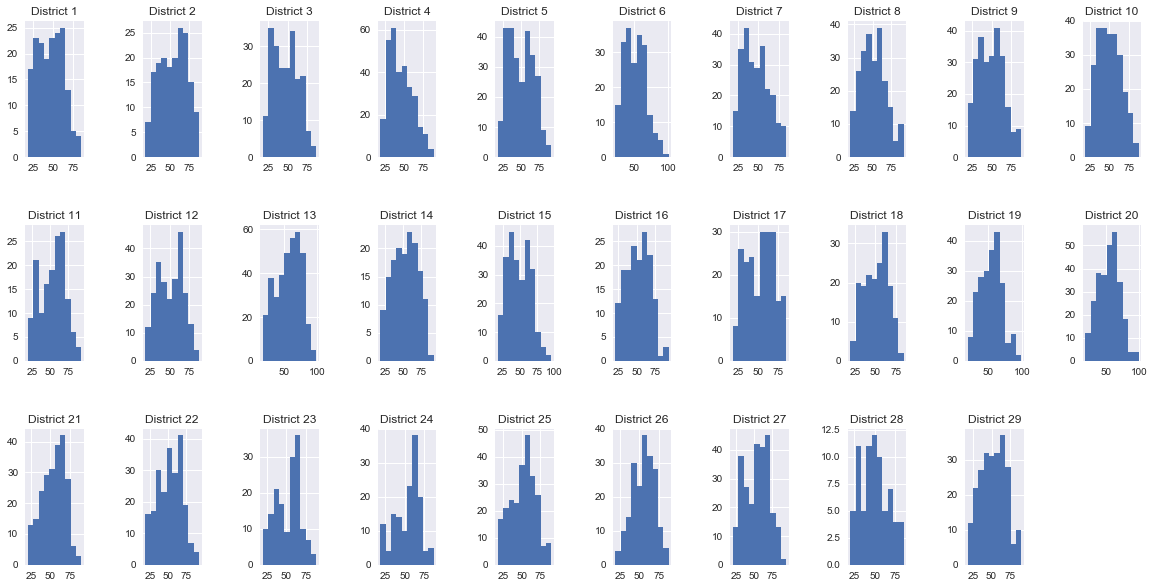

In [135]:
dists = set(ages.DISTRICT)
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.5, wspace=1)
for i in range(1, 30):
    ax = fig.add_subplot(3, 10, i)
    ax.hist(ages[(ages.Age < 110) & (ages.DISTRICT == i)]["Age"])
    ax.set_title("District " + str(i))

fig.show()
plt.show()

Districts where Mo performed well, i.e. Districts 1 through 10, are younger than average.

### Q1. How was turnout by district?

<img src="https://raw.githubusercontent.com/bdoohan/Jersey-City-Ward-D-Election/master/All%20Voters%20Prcnt%20Labels.jpeg" alt="Districts" height="700" width="700" align="right" hspace=0>
<p align="left">This chart breaks down voter turnout by District. The colors correspond to the percent of total voters that each district represents. Blue colors show districts that had a high percentage of the total votes.</p>  
<br clear="left"></br>
    <p>This chart shows the percet of total voters from each district. District 4, for example, had about 4.8% of the total votes.</p>
<br clear="left"></br>
    <p>Districts 13, 4, 5, 7 and 15 had high turnout. Overall, <b>the East side of the Heights came out and voted.</b> This is a section where Mo had strong support. The districts will be broken out for each candidate in the later sections.</p>
<br clear="left"></br>

<p>Here are the vote percentages for each district:</p> 

In [12]:
from IPython.display import display
pd.options.display.max_columns = None
tots = results[results.Dist_VotI!=31]["Voter_ID"].count()
adf = pd.DataFrame(
   100*(results[results.Dist_VotI!=31].groupby('Dist_VotI')["Voter_ID"].count()/tots)
)
adf["District"] = adf.index
adf.columns = ["Voter_Prcnt", "District"]
adf["District"] = adf.District.astype(int).copy()
adf[["District", "Voter_Prcnt"]].astype(object).T

Dist_VotI,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0
District,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Voter_Prcnt,2.8481,2.8481,3.35443,4.84177,4.36709,3.25949,3.9557,3.59177,4.03481,3.84494,2.34177,3.79747,5.77532,2.43671,3.98734,2.54747,3.37025,2.86392,3.37025,4.38291,3.60759,3.60759,2.54747,2.2943,3.84494,3.08544,4.11392,1.17089,3.71835


### Q2. What was the racial makeup of those who did vote?

Using [U.S. Census data](https://www.census.gov/topics/population/genealogy/data/2000_surnames.html), the race of each voter was identified. This method is not without its faults; however, it does serve as a functioning proxy for race classification.

#### White voters

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/Prcnt%20White%20Labels.jpeg?raw=true" alt="White_Voters" height="700" width="700" align="right" hspace=0>
<p align="left">This chart shows the percent of Ward D <b>white voters</b> for each District. Blue colors show districts that had a high percentage of the total <b>white voters</b>.</p>  
<br clear="left"></br>
    <p>Districts 4, 5, 7 and 9 have a high percentage of the total white votes. Overall, <b>the East side of the Heights is where much of the white voters live.</b> This is also a section where Mo had strong support.</p>
<br clear="left"></br>

#### Hispanic voters

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/Prcnt%20hispanic%20Labels.jpeg?raw=true" alt="Hispanic_Voters" height="700" width="700" align="right" hspace=0>
<p align="left">This chart shows the percent of Ward D <b>hispanic voters</b> for each District. Blue colors show districts that had a high percentage of the total <b>hispanic voters</b>.</p>  
<br clear="left"></br>
    <p>Districts 13, 20, 5, 27 and 22 have a high percentage of the total hispanic votes. Overall, <b>the North and West sides of the Heights are where much of the hispanic voters live.</b></p>
<br clear="left"></br>

#### Black voters

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/Prcnt%20Black%20Labels.jpeg?raw=true" alt="Black_Voters" height="700" width="700" align="right" hspace=0>
<p align="left">This chart shows the percent of Ward D <b>black voters</b> for each District. Blue colors show districts that had a high percentage of the total <b>black voters</b>.</p>  
<br clear="left"></br>
    <p>Districts 12, 13, and 20 have a high percentage of the total black votes. Overall, <b>the center of the Heights is where much of the black voters live.</b></p>
<br clear="left"></br>

#### Asian voters

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/Prcnt%20Asian%20Labels.jpeg?raw=true" alt="Asian_Voters" height="700" width="700" align="right" hspace=0>
<p align="left">This chart shows the percent of Ward D <b>Asian voters</b> for each District. Blue colors show districts that had a high percentage of the total <b>Asian voters</b>.</p>  
<br clear="left"></br>
    <p>Districts 22, 23, 25, 27 and 29 have a high percentage of the total Asian votes. Overall, <b>the westside of the Heights is where much of the Asian voters live.</b></p>
<br clear="left"></br>

### Q3. Did Mo's supporters come out and vote?

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/Mo%20Supporters%20Prcnt%20Labels.jpeg?raw=true" alt="Mo_supporters" height="700" width="700" align="right" hspace=0>
<p align="left">This chart shows where most of Mo's supporters live in Ward D. Blue colors show districts that had a high percentage of <b>Mo's supporters</b>.</p>  
<br clear="left"></br>
    <p>Districts 4, 7 and 13 have a high percentage of Mo's supporters. Overall, <b>Mo's supporters live east of Central Avenue and near Congress Street.</b></p>
<br clear="left"></br>

Overall, **52%** of Mo's supporters voted on Election Day. Here is the **percent turnout** by District:

In [33]:
results_mo["turnout_rate"] = results_mo.voted.astype(float)/results_mo.mo_supporter.astype(float)
results_mo["turnout_rate"] = results_mo["turnout_rate"].astype(float)

In [34]:
results_mo  = results_mo[results_mo["Dist_VotI_y"] != 'District'].copy()

In [35]:
results_mo["Dist_VotI_x"] = results_mo["Dist_VotI_x"].astype(float)
results_mo["Dist_VotI_y"] = results_mo["Dist_VotI_y"].astype(float)

In [36]:
results_mo["District"] = results_mo[["Dist_VotI_x", "Dist_VotI_y"]].max(axis=1)

In [37]:
turnout = pd.DataFrame(results_mo.groupby("District")["turnout_rate"].mean())
turnout["District"] = turnout.index
turnout = turnout[turnout.District.between(1,29)]

In [38]:
turnout["District"] = turnout.District.astype(int)

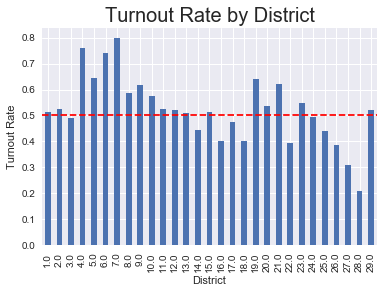

In [39]:
import math 
turnout.set_index(turnout.District)
turnout.turnout_rate.plot(kind="bar")
plt.xlabel("District")
plt.ylabel("Turnout Rate")
plt.title("Turnout Rate by District", fontsize=20)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

<p align="left"> Districts <b>4, 5, 6, 7 and 19</b> stood out from the rest. Mo's base in <b>the eastern section of the Heights</b> did come out and vote. However, supporters outside of this section largely failed to come out on Election day.</p>

### Q4. Where did Mo perform best? How about the rest fo the candidates?

**N.B.** Color coding is specific to each candidate. Red colors show where the candidate did worse relative to his/her average number of votes. Blue shows where they did above average.

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/Mo%20Total%20Labels.jpeg?raw=true" alt="Mo_Voters" height="700" width="700" align="right" hspace=0>
<p align="left">This chart shows the <b>total</b> votes for Mo for each District. Blue colors show districts with higher vote counts.</p>  
<br clear="left"></br>
    <p>Districts <b>3, 4, 5, 7, 8, 9 and 10</b> were the best for Mo.</p>
<br clear="left"></br>

### Yun

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/Yun%20Total%20Labels.jpeg?raw=true" alt="Yun_Voters" height="700" width="700" align="right" hspace=0>
<p align="left">This chart shows the <b>total</b> votes for Yun for each District. Blue colors show districts with higher vote counts.</p>  
<br clear="left"></br>
<p align="left">Yun did well on the Western Slope and in the hispanic neighborhoods.</p>  


### Vega

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/Carmen%20Total%20Labels.jpeg?raw=true" alt="Yun_Voters" height="700" width="700" align="right" hspace=0>
<p align="left">This chart shows the <b>total</b> votes for Vega for each District. Blue colors show districts with higher vote counts.</p>  
<br clear="left"></br>
<p align="left">Vega had low turnout in most districts.</p> 

### Torres

<img src="https://github.com/bdoohan/Jersey-City-Ward-D-Election/blob/master/Torres%20Totals%20Labels.jpeg?raw=true" alt="Yun_Voters" height="700" width="700" align="right" hspace=0>
<p align="left">This chart shows the <b>total</b> votes for Torres for each District. Blue colors show districts with higher vote counts.</p>  
<br clear="left"></br>
<p align="left">Torres had low turnout across Ward D.</p> 

### Q5. How did the model do at predicting whether someone was going to vote?

For Mo's campaign a [Random Forest](https://en.wikipedia.org/wiki/Random_forest) model was used to predict who would vote. The model assigned a likelihood of voting to each voter. A likelihood close to 0 meant that the person was unlikely to vote; a value closer to 1 meant they were likely to vote. These predictions were then used to focus canvassing and phone banking efforts. 

Usually any likelihood greater than .50 (50%) is interpreted as a positive event. So, for example, if someone's likelihood was 0.55, they would be labelled as likely to vote. However, for this campaign, a decision was made to only label people with likelihoods of 0.85 or higher as people likely to vote. This made the model's predictions much more accurate. 

Using the 0.85 likelihood cutoff, the model had an accuracy of **75%**. This means that the model correctly predicted whether or not a voter would vote 75% of the time. Part of this success is due to the fact that turnout overall was low. Many people did not come out and vote, compared to previous elections. That is, having a high cutoff value of 85% meant that most people were predicted not to vote. This is exactly what happened since turnout was so low.

### Summary

- **Demographic**  
    
    - Mo won the white vote on the eastern side of the Ward  
    - Mo lost the Western Slope, which is predominantly asian 
    - Mo performed well among younger voters.

    

- **Geographic**  

    - Mo struggled west of Central Avenue
    - Mo did well east of Central Avenue    

   

- **Base health**  

    - 52% of Mo's supporters came out to vote
    - Most of this turnout came from supporters east of Central Avenue



- **Competitors**  
    
    - Yun did well across most districts, with strong performance in the asian and hispanic neighborhoods



- **Change Research Survey**  
    
    - The survey indicated that those who knew Mo liked her and would vote for her
    - Data from the election confirm this finding, showing that Mo did well where most of her supporters lived
    - Survey had Yun with 62% and Mo with 30%; actual results were Yun 52% and Mo with 38%

## Code

In [14]:
def get_last(string):
    return(str(string).split("|")[0])
def get_first(string):
    try:
        return(str(string).split("|")[1])
    except:
        return("")
def get_middle(string):
    try:
        return(str(string).split("|")[2])
    except:
        return("")

results["last_name"] = results.Voter_Name.apply(get_last)
results["first_name"] = results.Voter_Name.apply(get_first)
results["middle_name"] = results.Voter_Name.apply(get_middle)

In [15]:
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/most-common-name/surnames.csv'
races = pd.read_csv(url,index_col=0)

In [16]:
races["last_name"] = races.index
races = races.reset_index()

In [17]:
def get_race(arow): 
    if arow["pctblack"]=="((S))":
        arow["pctblack"] = 0.00
    if arow["pctaian"]=="((S))":
        arow["pctaian"] = 0.00
    try:
        guess = arow[["pctwhite", "pctblack", "pctapi", "pctaian", "pct2prace", "pcthispanic"]].astype(float).idxmax(axis=1)
        return(guess)
    except:
        return("Unidentified")

In [18]:
mapping = {'(S)':.00001}
races = races.replace({'pctblack': mapping, 'pctaian': mapping,
               'pctwhite': mapping, 'pctapi': mapping, 
               'pct2prace': mapping, 'pcthispanic': mapping})

In [19]:
races["guess"] = races.apply(lambda x: get_race(x), axis=1)

In [20]:
races["guess"] = races.guess.str.replace("pct", "")

In [21]:
results_race = pd.merge(results, races, on="last_name", how="left")

In [22]:
results_race.guess.fillna("Unidentified", inplace=True)

In [23]:
mo_base = pd.read_csv("Election Day Mo Supporter List - Master 11052017.csv", 
                     names = ["first_name", "last_name", "full_name", "address", "Dist_VotI", "email", "phone"])

In [24]:
mo_base["mo_supporter"] = int(1)

In [25]:
results['first_name'] = results['first_name'].apply(lambda x: x.strip(" "))
results['first_name'] = results['first_name'].apply(lambda x: x.upper())

In [26]:
results['last_name'] = results['last_name'].apply(lambda x: x.strip(" "))
results['last_name'] = results['last_name'].apply(lambda x: x.upper())

In [27]:
mo_base['first_name'] = mo_base['first_name'].astype(str).apply(lambda x: x.strip(" "))
mo_base['last_name'] = mo_base['last_name'].astype(str).apply(lambda x: x.strip(" "))
mo_base['first_name'] = mo_base['first_name'].astype(str).apply(lambda x: x.split(',', 1)[0])
mo_base['last_name'] = mo_base['last_name'].apply(lambda x: x.upper())
mo_base['first_name'] = mo_base['first_name'].apply(lambda x: x.upper())

In [28]:
results["voted"] = int(1)

In [29]:
results_mo = pd.merge(results, mo_base[["first_name", "last_name", "mo_supporter", "Dist_VotI"]],
                          on=["last_name", "first_name"], how="right")

In [30]:
results_mo.drop_duplicates(inplace=True, subset=["Voter_ID", "last_name", "first_name", "voted", "mo_supporter"])

In [31]:
results_mo.fillna(0, inplace=True)

In [45]:
results_race_mo = pd.read_csv("results_race_mo.csv")
x = results_race_mo.groupby(["Dist_VotI", "guess"])["Voter_ID"].count().unstack()
races_dist = pd.DataFrame(x)
races_dist["District"] = races_dist.index

In [46]:
x = results_race_mo.groupby("Dist_VotI")["Voter_ID"].count()
votes = pd.DataFrame(x)
votes["District"] = votes.index

In [47]:
mo_groupby = mo_base.groupby("Dist_VotI", as_index=False).mo_supporter.count() 

In [48]:
results_race_mo["Dist_VotI"] = results_race_mo.Dist_VotI.astype(str).copy()

In [49]:
mo_groupby["Dist_VotI"] = mo_groupby.Dist_VotI.astype(str).copy()

In [50]:
results_race_mo["Dist_VotI"] = results_race_mo.Dist_VotI.copy()

In [51]:
results_groupby = pd.DataFrame(
        results_race_mo.groupby(["Dist_VotI", "mo_supporter"])["Voter_ID"].count().fillna(0).replace('NaN', 0)
    )

In [53]:
results_groupby = results_groupby.unstack()
#results_groupby["Dist_VotI"] = results_groupby.index
#results_groupby["Dist_VotI"] = results_groupby["Dist_VotI"].round(0)

In [54]:
mo_groupby = mo_groupby.convert_objects(convert_numeric=True)

In [60]:
results_groupby["Dist_VotI"] = results_groupby.index

In [83]:
mo_turnout = pd.merge(
    results_groupby,
    mo_groupby,
    on="Dist_VotI",
    how="left")

In [64]:
mo_turnout.columns = ["District", "Total_Voters", "Mo_Voters", "District_x", "Mo_supporters"]

In [65]:
mo_turnout["turnout_rate"] = mo_turnout["Mo_Voters"]/ mo_turnout.Mo_supporters

In [137]:
import matplotlib.pyplot as plt
#import plotly.plotly as py
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

#y = mo_turnout.turnout_rate
#x = mo_turnout.District
#width = 1/1.5
#plt.bar(x, y, width, color="blue")
#fig = plt.gcf()
#plot_url = py.plot_mpl(fig, filename='mpl-basic-bar')
#plt.show()

In [68]:
probs = pd.read_csv("voters_with_petition_flag.csv")

In [69]:
probs["Voter_ID"] = probs["VOTER.ID"].astype(str)
results_race_mo["Voter_ID"] = results_race_mo["Voter_ID"].astype(str) 

In [70]:
model_eval = pd.merge(probs[["Voter_ID", "LAST.NAME", "FIRST.NAME", 
                             "likely_to_vote"]], results_race_mo, on="Voter_ID", how="left")

In [71]:
model_eval = pd.read_csv("model_eval.csv")

In [72]:
#model_eval.to_csv("model_eval.csv", index=False)

In [73]:
model_eval["pred_vote"] = model_eval.likely_to_vote.apply(lambda x: 1 if x>0.85 else 0)

In [74]:
import math
model_eval["act_vote"] = model_eval.Voter_Name.apply(lambda x: 0 if pd.isnull(x) == True else 1)

In [75]:
model_eval_deduped = pd.DataFrame(
    model_eval.fillna(0).groupby(["Voter_ID", "LAST.NAME", "FIRST.NAME"])[["Dist_VotI", "pred_vote", "act_vote"]].max()
)

In [76]:
model_eval_deduped["Voter_ID"] = model_eval_deduped.index.get_level_values(0)
model_eval_deduped["LAST.NAME"] = model_eval_deduped.index.get_level_values(1)
model_eval_deduped["FIRST.NAME"] = model_eval_deduped.index.get_level_values(2)

In [77]:
model_eval_deduped.sort_values("Voter_ID", inplace=True)

In [78]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score